In [ ]:
# STACKED PAIR MAP

Stacking galaxies:   0%|          | 0/13098 [00:00<?, ?it/s]

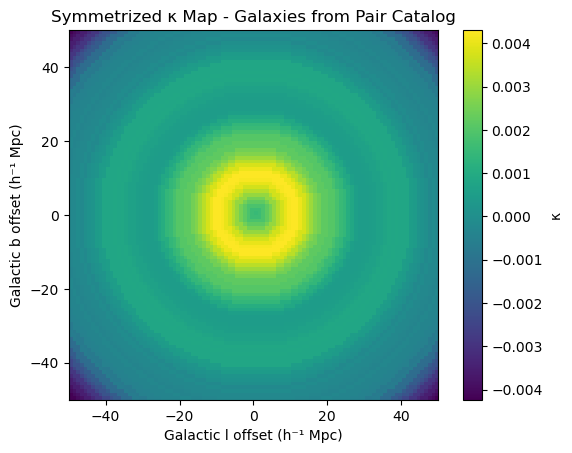

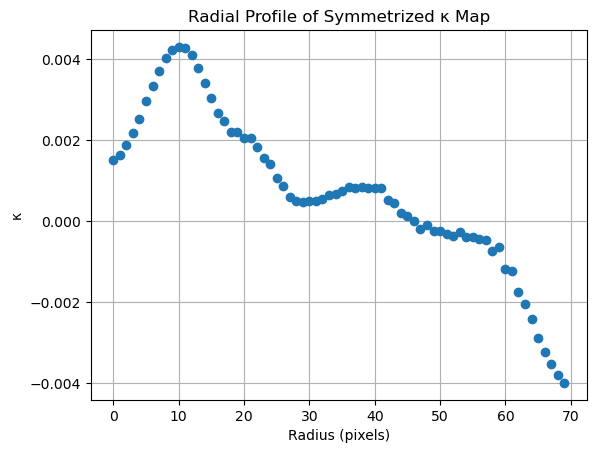

array([ 1.52127924e-03,  1.62453610e-03,  1.87885694e-03,  2.18718417e-03,
        2.52621786e-03,  2.96524855e-03,  3.34915090e-03,  3.71867272e-03,
        4.02125324e-03,  4.22425054e-03,  4.30431404e-03,  4.27557402e-03,
        4.09680468e-03,  3.77743729e-03,  3.42051141e-03,  3.04216624e-03,
        2.68455563e-03,  2.47145269e-03,  2.19397989e-03,  2.19376171e-03,
        2.06384423e-03,  2.05227813e-03,  1.82581885e-03,  1.56707300e-03,
        1.41321296e-03,  1.07862113e-03,  8.76579407e-04,  5.91620763e-04,
        5.01414026e-04,  4.70970259e-04,  4.94400340e-04,  5.03991293e-04,
        5.60556756e-04,  6.35859959e-04,  6.62755015e-04,  7.42093991e-04,
        8.40535420e-04,  8.15684767e-04,  8.48946823e-04,  8.09699048e-04,
        8.27785237e-04,  8.20406877e-04,  5.27216473e-04,  4.61642892e-04,
        2.01807814e-04,  1.25624153e-04,  1.45582816e-05, -1.84011206e-04,
       -8.26514386e-05, -2.41588359e-04, -2.42833250e-04, -3.13284602e-04,
       -3.66633899e-04, -

In [42]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
import pandas as pd

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)  # 8 arcmin smoothing
grid_size = 100
box_size_hmpc = 100
h = cosmo.h
box_size_mpc = box_size_hmpc * h
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2
extent = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load pairs catalog ---
pairs = pd.read_csv('data/galaxy_pairs_catalog.csv')

# Extract singular galaxies (concatenate both sides of pairs)
l_all = np.deg2rad(np.concatenate([pairs['l1'], pairs['l2']]))
b_all = np.deg2rad(np.concatenate([pairs['b1'], pairs['b2']]))
z_all = np.concatenate([pairs['z1'], pairs['z2']])
D_all = cosmo.comoving_distance(z_all).value  # Mpc/h

weights = np.ones(len(l_all))  # equal weights

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        dl = (off_x / D / np.cos(b)) * (180 / np.pi)
        db = (off_y / D) * (180 / np.pi)

        l_grid = np.rad2deg(l) + dl
        b_grid = np.rad2deg(b) + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Symmetrize map ---
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()
    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

# --- Radial profile ---
def radial_profile(arr, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat = arr.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    prof = S / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()
    return prof

# --- Run stacking ---
kappa_stack = stack_kappa(l_all, b_all, D_all, weights)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, "Radial Profile of Symmetrized κ Map")


Stacking galaxies:   0%|          | 0/20000 [00:00<?, ?it/s]

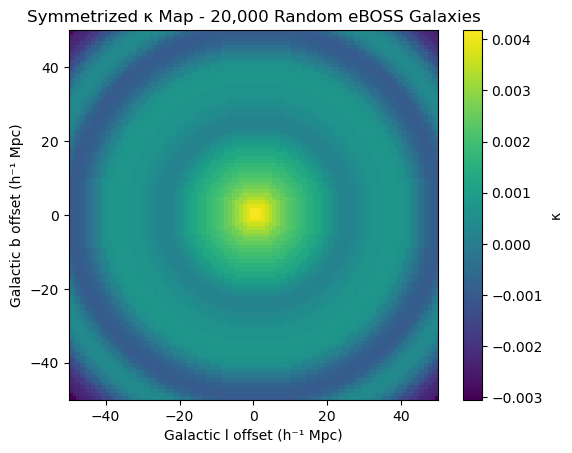

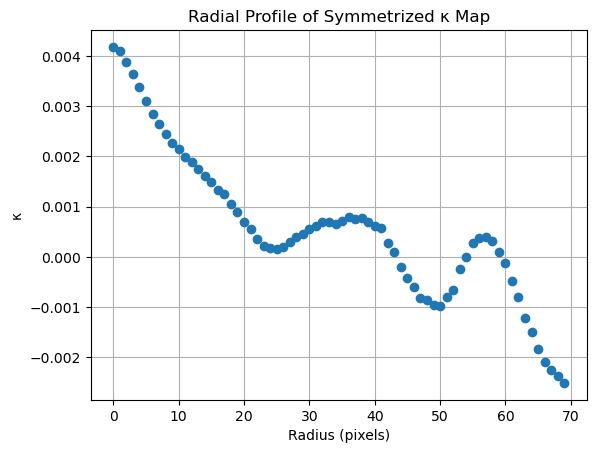

array([ 4.17827544e-03,  4.09286130e-03,  3.88704768e-03,  3.64047335e-03,
        3.37876442e-03,  3.09829741e-03,  2.83534394e-03,  2.64187153e-03,
        2.44282893e-03,  2.27285978e-03,  2.14102294e-03,  1.97948489e-03,
        1.88116083e-03,  1.75418797e-03,  1.60832713e-03,  1.49278912e-03,
        1.34104269e-03,  1.24979649e-03,  1.04972535e-03,  8.91337757e-04,
        7.04218010e-04,  5.56999616e-04,  3.52795211e-04,  2.24730588e-04,
        1.76019701e-04,  1.64777794e-04,  2.04058325e-04,  2.98409978e-04,
        4.02608749e-04,  4.61918458e-04,  5.52884523e-04,  6.12729684e-04,
        6.91472519e-04,  6.86464104e-04,  6.60472731e-04,  7.11485862e-04,
        7.89006110e-04,  7.51352451e-04,  7.77110739e-04,  7.04152595e-04,
        6.23673551e-04,  5.70069113e-04,  2.72823295e-04,  1.05144719e-04,
       -1.94266465e-04, -4.19428157e-04, -6.04669040e-04, -8.11312810e-04,
       -8.49427645e-04, -9.48956918e-04, -9.70282602e-04, -7.99211948e-04,
       -6.49891236e-04, -

In [37]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter

# --- Settings and constants ---
nside = 2048
fwhm_rad = np.radians(8 / 60)  # 8 arcmin smoothing
grid_size = 100
box_size_hmpc = 100
h = cosmo.h
box_size_mpc = box_size_hmpc * h
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2
extent = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load original eBOSS catalog ---
real_file = "data/eBOSS/eBOSS_LRG_clustering_data-NGC-vDR16.fits"
with fits.open(real_file) as hd:
    cat = hd[1].data
cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
z_all = cat['Z']
ra_all = cat['RA']
dec_all = cat['DEC']

def fast_icrs_to_galactic(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    R = np.array([
        [-0.0548755604, -0.8734370902, -0.4838350155],
        [ 0.4941094279, -0.4448296300,  0.7469822445],
        [-0.8676661490, -0.1980763734,  0.4559837762]
    ])
    xg, yg, zg = np.dot(R, np.array([x, y, z]))
    b_rad = np.arcsin(zg)
    l_rad = np.arctan2(yg, xg)
    l_deg = np.degrees(l_rad) % 360
    b_deg = np.degrees(b_rad)
    return l_deg, b_deg

l_all, b_all = fast_icrs_to_galactic(ra_all, dec_all)
D_all = cosmo.comoving_distance(z_all).value  # Mpc/h

# --- Select 20,000 random galaxies ---
num_random = 20000
total_gal = len(l_all)
indices = np.random.choice(total_gal, min(num_random, total_gal), replace=False)

l_rand = l_all[indices]
b_rand = b_all[indices]
D_rand = D_all[indices]
weights_rand = np.ones(len(l_rand))

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        dl = (off_x / D / np.cos(np.radians(b))) * (180 / np.pi)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Symmetrize map ---
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()
    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

# --- Radial profile ---
def radial_profile(arr, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat = arr.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    prof = S / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()
    return prof

# --- Run stacking ---
kappa_stack = stack_kappa(l_rand, b_rand, D_rand, weights_rand)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - 20,000 Random eBOSS Galaxies")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, "Radial Profile of Symmetrized κ Map")